In [9]:
import os 
import pickle
import random
import shutil
import zipfile
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Загрузка данных

Данные  - фотографии документов, которые выравнены верно 

In [10]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
img_zip = '/content/gdrive/MyDrive/FlipNet/img.zip'
zipfile_img = zipfile.ZipFile(img_zip, 'r')
zipfile_img.extractall()

## Генерация классов

создаем копиb каждой фотографии переварачивая ее на 90 градусов

In [12]:
! mv img flip0

In [13]:
!mkdir flip90 flip180 flip270

In [14]:
def rotate_img(list_imgs, rot):
    for img in list_imgs:
        if len(img) > 10:
            im = Image.open(os.path.join('flip0', img))
            im_rotate = im.rotate(rot, expand=True)
            im_rotate.save(os.path.join(f"flip{rot}", img))
            im.close()
 
images = [x for x in os.listdir('flip0')]
rotate_img(images, 90)
rotate_img(images, 180)
rotate_img(images, 270)

## Разделим данные на Train и Test

In [15]:
all_images = [[os.path.join('flip0', x), os.path.join('flip90', x), os.path.join('flip180', x), os.path.join('flip270', x)] for x in os.listdir('flip0')]
all_images = np.concatenate(np.array(all_images))
train_images, test_images = train_test_split(all_images, test_size=0.3, random_state=42)

In [16]:
!mkdir images images/train images/train/flip0 images/train/flip90 images/train/flip180 images/train/flip270
!mkdir images/test images/test/flip0 images/test/flip90 images/test/flip180 images/test/flip270

In [17]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            if f.find('.DS_Store') != -1:
                continue
            prefix = f.split('/', 1)[0]
            shutil.move(f, os.path.join(destination_folder, prefix))
        except:
            print(f)
            assert False

# перетащим файлы по нужным папкам
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(test_images, 'images/test/')

In [18]:
! rm -rf flip0 flip90 flip180 flip270  img

In [19]:
len(os.listdir('images/train/flip0')), len(os.listdir('images/train/flip90')), len(os.listdir('images/train/flip180')), len(os.listdir('images/train/flip270'))

(282, 281, 277, 277)

## Подготовка данных 

разобьем данные на бачи

In [29]:
def augmentation(train_dir = 'train'):
    # mas = [transforms.ColorJitter(brightness=.5, hue=.3), transforms.RandomRotation(degrees=(-5, 5)),
    # transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.3), scale=(0.5, 0.75)), transforms.RandomEqualize(p=1),
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 3)), transforms.AugMix(),
    # transforms.RandomPerspective(distortion_scale=0.3, p=1.0)]

    mas = [transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.3), scale=(0.5, 0.75)), transforms.RandomEqualize(p=1),
    transforms.AugMix(), transforms.RandomPerspective(distortion_scale=0.2, p=1.0)]
    head = [transforms.Resize((224, 224))]
    end = [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    com_mas = []
    for i in range(len(mas)):
        com_mas.append(transforms.Compose(head + [mas[i]] + end))
        for j in range(i+1, len(mas)):
            com_mas.append(transforms.Compose(head + [mas[i], mas[j]] + end))
            for l in range(j+1, len(mas)):
                if l > j+2:
                    break
                com_mas.append(transforms.Compose(head + [mas[i], mas[j], mas[l]] + end))
    dataset_mas = []
    for com in com_mas:
        dataset_mas.append(torchvision.datasets.ImageFolder(train_dir, com))
        
    return torch.utils.data.ConcatDataset(dataset_mas)

# ColorJitter и RandomAffine мб два раза? 

In [34]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dir = 'images/train'
val_dir = 'images/test'

train_dataset = augmentation(train_dir)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [31]:
print(len(train_dataset)) ## кол-во всех фотографий
print(len(train_dataloader)) ## кол-во батчей
print(train_dataset[0][0].shape) ## размерность изображения

26808
3351
torch.Size([3, 224, 224])


 #### Посмотрим как теперь выглядят наши фотографии

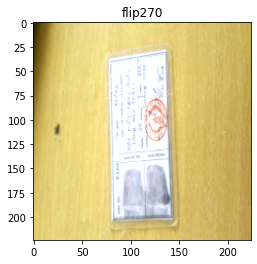

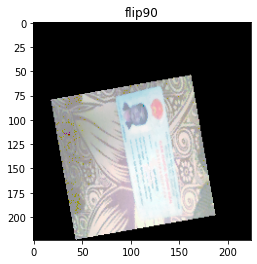

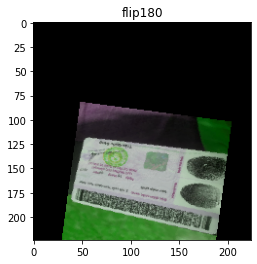

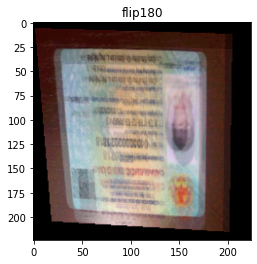

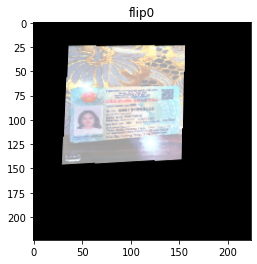

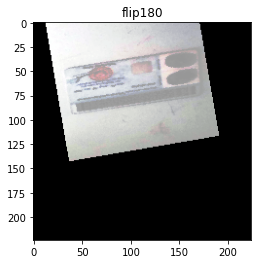

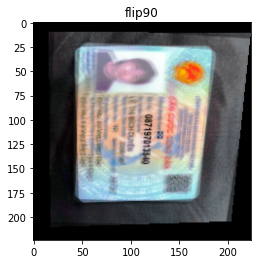

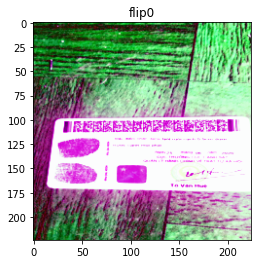

In [33]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
class_names = ['flip0', 'flip180', 'flip90', 'flip270']
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Объявление модели

In [35]:
model = models.resnet18(pretrained=True)

"""отключить рассчет градиента для всех слоев сети
сеть хорошо предобучена и мы не хотим, что бы веса менялись во время обучения
"""
for param in model.parameters():
    param.requires_grad = False

"""меняем последний слой, вместо 1000 классов, как в оригинале, у нас будет 4
"""
model.fc = torch.nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss = torch.nn.CrossEntropyLoss() # функция активации 
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) # метод оптимизации
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # планировщик

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Тренировка модели

In [36]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epochs in range(num_epochs):
        print(f'Epoch {epochs + 1} / {num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
            true_ans, total, all_loss = 0, 0, 0
            for inputs, label in tqdm(dataloader):
                inputs, label = inputs.to(device), label.to(device)
                optimizer.zero_grad() # обнуляем градиент, что бы он не накапливался
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, label)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                true_ans += (preds_class == label).sum().item()
                total += label.size(0)
                all_loss += loss_value.item()

            print(f"{phase} accuracy of the network {100 * true_ans / total}, Loss {all_loss}")
    return model

In [38]:
flipmodel = train_model(model, loss, optimizer, scheduler, num_epochs=1);

Epoch 1 / 1


100%|██████████| 3351/3351 [10:06<00:00,  5.53it/s]


train accuracy of the network 77.41718889883617, Loss 1876.1555746793747


100%|██████████| 60/60 [00:08<00:00,  6.92it/s]

val accuracy of the network 85.38622129436325, Loss 22.671436112374067


In [40]:
flipmodel = train_model(flipmodel, loss, optimizer, scheduler, num_epochs=1);

Epoch 1 / 1


100%|██████████| 3351/3351 [10:21<00:00,  5.39it/s]


train accuracy of the network 77.87973739182334, Loss 1844.5851099677384


100%|██████████| 60/60 [00:07<00:00,  7.82it/s]

val accuracy of the network 87.89144050104385, Loss 21.491277016699314


## Сохранение модели

In [41]:
with open('model.pickle', 'wb') as f:
    pickle.dump(flipmodel, f)

# with open('/content/gdrive/My Drive/FlipNet/model.pickle', 'rb') as f:
#     flipmodel = pickle.load(f)

In [42]:
%cp model.pickle /content/gdrive/My\ Drive/FlipNet/

## Тестирование 

In [43]:
def predict(model):
    model.eval() ## фиксируем модельку 
    test_predictions, true_predictions = [], []
    for inputs, labels in tqdm(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            np.argmax(torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy(), axis=1))
        true_predictions.append(labels.data.cpu().numpy())
    return np.concatenate(true_predictions), np.concatenate(test_predictions)

In [44]:
true_predict, my_predict = predict(flipmodel)

100%|██████████| 60/60 [00:09<00:00,  6.41it/s]


In [45]:
print(classification_report(true_predict, my_predict))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       117
           1       0.84      0.93      0.89       122
           2       0.89      0.86      0.88       122
           3       0.87      0.85      0.86       118

    accuracy                           0.88       479
   macro avg       0.88      0.88      0.88       479
weighted avg       0.88      0.88      0.88       479



In [46]:
true_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [47]:
my_predict

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2,